# 0. Setting Up The Env.

## 0.1 Import Packages

In [45]:
from pathlib import Path

In [46]:
import numpy as np
import pandas as pd

import itertools


In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

## 0.2 Utilities

In [50]:
def plot_distributions(df, target_col):
    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue

        plt.figure(figsize=(3, 3))
        sns.kdeplot(
            data=df, x=col, hue=target_col,
            common_norm=False, fill=True, alpha=0.4
        )
        plt.title(f"Distribution of {col} by {target_col}")
        plt.show()  

In [51]:
def cap_to_99(df):
    df_capped = df.copy()
    for col in df_capped.columns:
        cap_value = df_capped[col].quantile(0.99)
        df_capped[col] = df_capped[col].clip(upper=cap_value)
    return df_capped


## 0.3 Constants

In [52]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [53]:
processed_file_path = f"{project_root}/data/processed/preprocessed_bank_2.csv"

processed_file_path

'd:\\01 Work\\06-Segmentations/data/processed/preprocessed_bank_2.csv'

In [54]:
capped_file_path = f"{project_root}/data/processed/capped_2.csv"
target_file_path = f"{project_root}/data/processed/target_2.csv"
capped_file_path, target_file_path

('d:\\01 Work\\06-Segmentations/data/processed/capped_2.csv',
 'd:\\01 Work\\06-Segmentations/data/processed/target_2.csv')

# 1. The Data

In [55]:
data_df  = pd.read_csv(processed_file_path)
print(f"The data has {data_df.shape[0]} rows and {data_df.shape[1]} columns")
print("Data Preview:")
data_df.head()

The data has 3811 rows and 43 columns
Data Preview:


,age,housing,loan,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,poutcome_failure,poutcome_nonexistent,poutcome_success,contact_cellular,contact_telephone
0,30,1,0,487,2,999,0,-1.8,92.893,-46.2,...,1,0,0,0,0,0,1,0,1,0
1,39,0,0,346,4,999,0,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,1
2,25,1,0,227,1,999,0,1.4,94.465,-41.8,...,0,1,0,0,0,0,1,0,0,1
3,47,1,0,58,1,999,0,-0.1,93.200,-42.0,...,0,0,0,0,1,0,1,0,1,0
4,32,0,0,128,3,999,2,-1.1,94.199,-37.5,...,0,0,0,0,1,1,0,0,1,0


In [56]:
data_df.columns

Index(['age', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y', 'sin_month', 'cos_month', 'sin_day_of_week',
       'cos_day_of_week', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success',
       'contact_cellular', 'contact_telephone'],
      dtype='object')

# 2. Outlier Analysis

In [57]:
X = data_df.drop("y", axis=1)
y = data_df.loc[:,"y"]

## 2.1 Before Analysis

In [58]:
display(X.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,3811.0,39.961952,10.215878,19.000000,32.000000,3.800000e+01,47.000000,88.000000
housing,3811.0,0.543689,0.498153,0.000000,0.000000,1.000000e+00,1.000000,1.000000
loan,3811.0,0.166361,0.372453,0.000000,0.000000,0.000000e+00,0.000000,1.000000
duration,3811.0,256.496982,256.815753,0.000000,103.000000,1.800000e+02,316.000000,3643.000000
campaign,3811.0,2.539491,2.590149,1.000000,1.000000,2.000000e+00,3.000000,35.000000
pdays,3811.0,961.467331,189.427840,0.000000,999.000000,9.990000e+02,999.000000,999.000000
previous,3811.0,0.184204,0.523136,0.000000,0.000000,0.000000e+00,0.000000,6.000000
emp.var.rate,3811.0,0.088113,1.557160,-3.400000,-1.800000,1.100000e+00,1.400000,1.400000
cons.price.idx,3811.0,93.575567,0.578653,92.201000,93.075000,9.344400e+01,93.994000,94.767000
cons.conf.idx,3811.0,-40.560798,4.602293,-50.800000,-42.700000,-4.180000e+01,-36.400000,-26.900000


## 2.2 Distribution

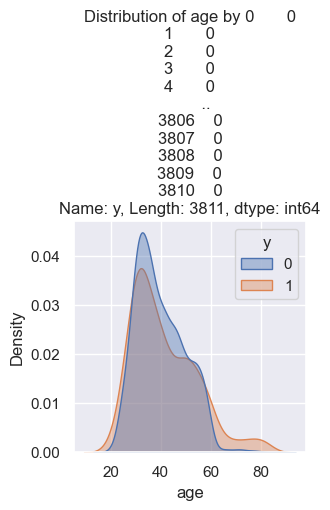

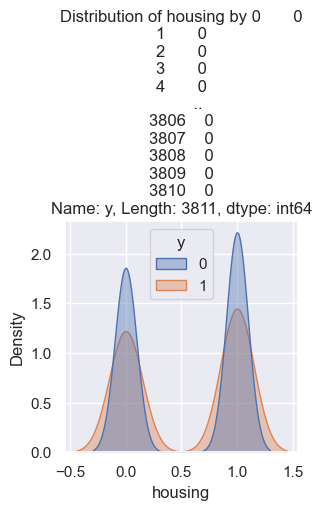

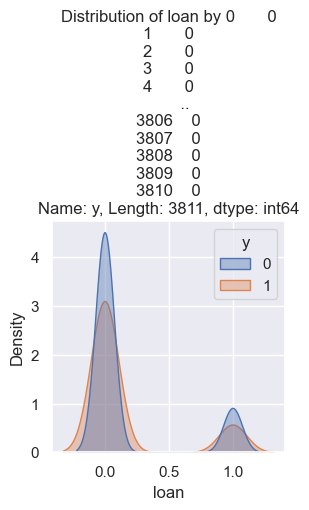

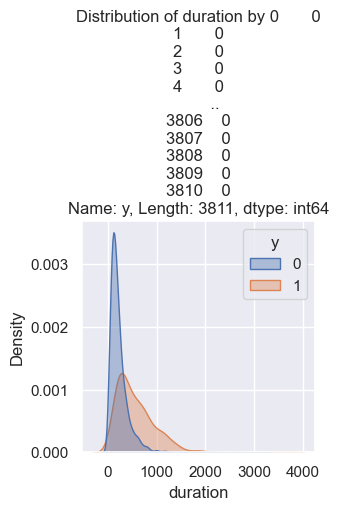

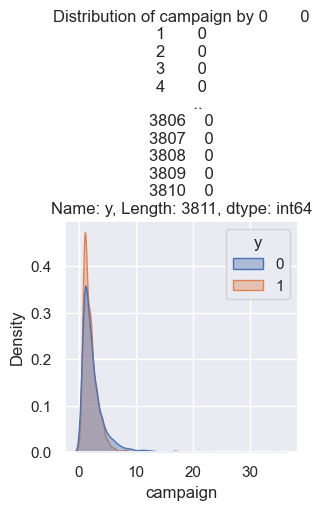

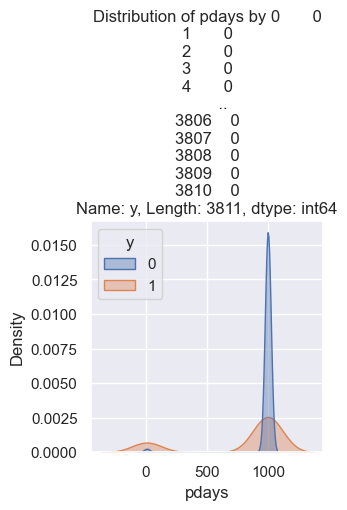

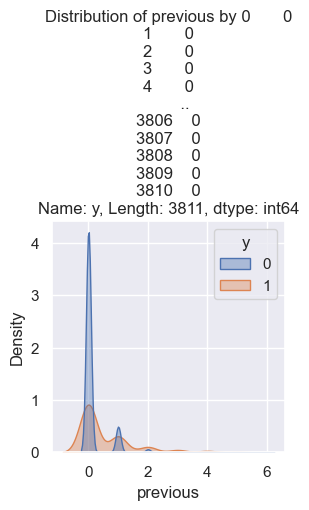

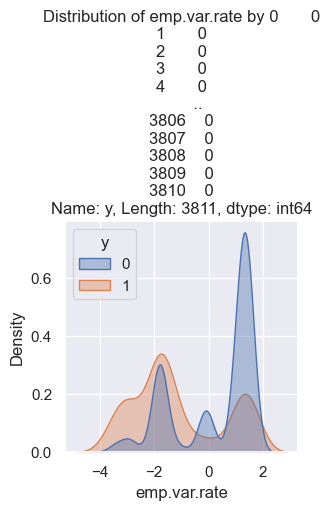

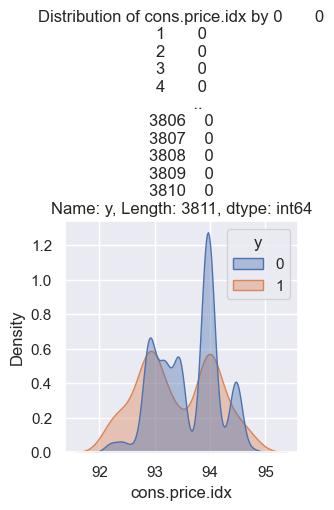

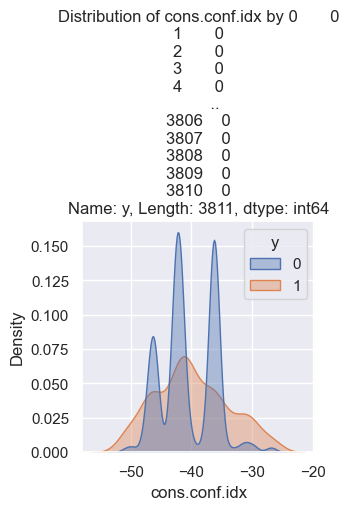

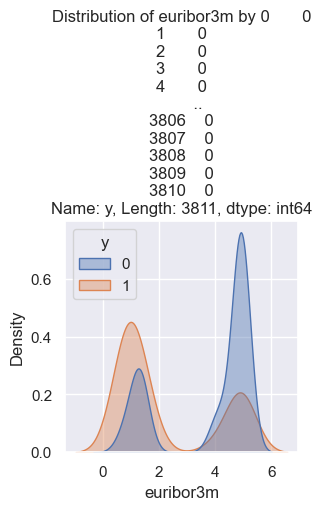

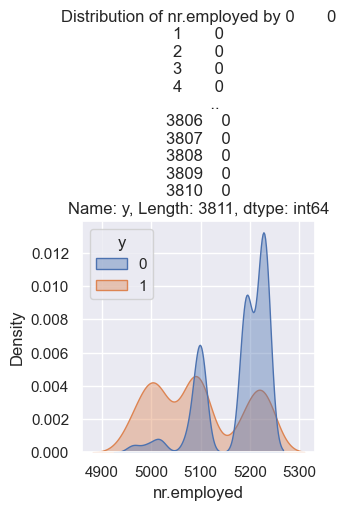

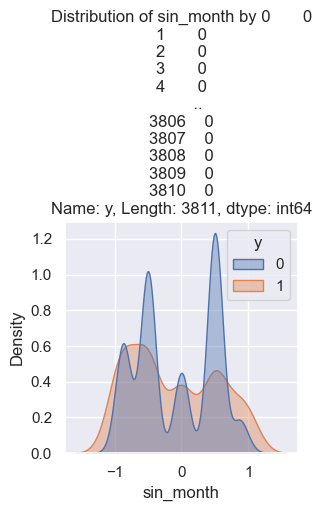

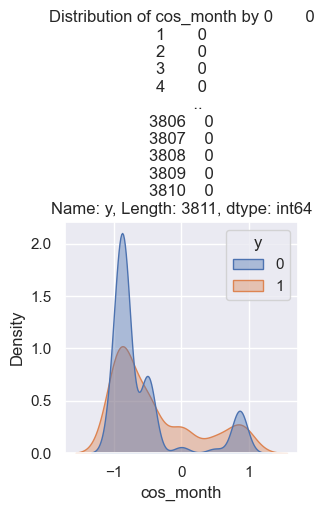

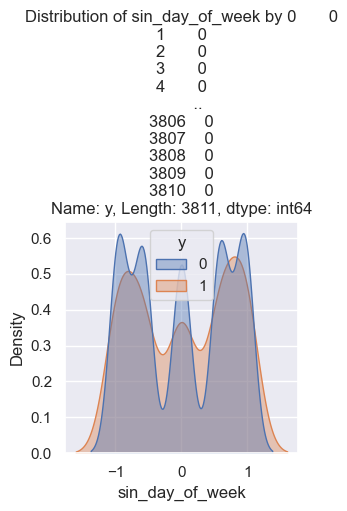

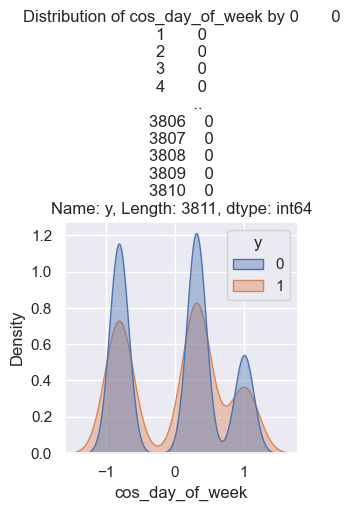

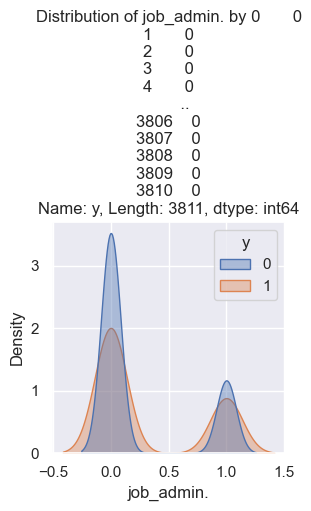

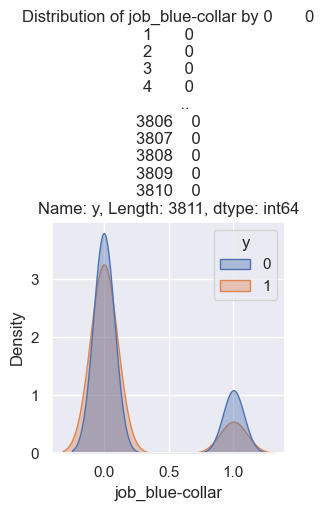

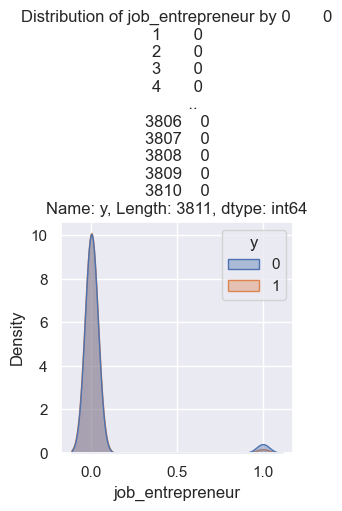

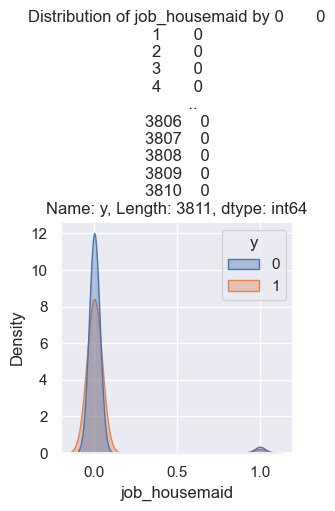

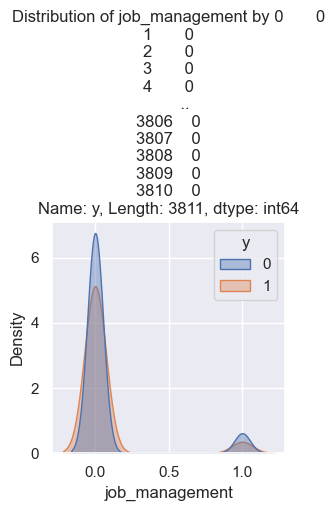

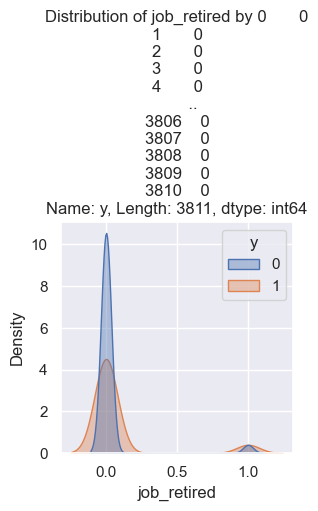

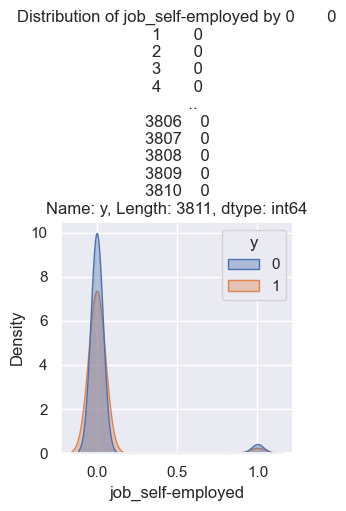

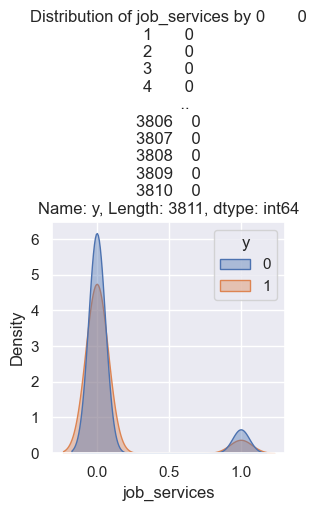

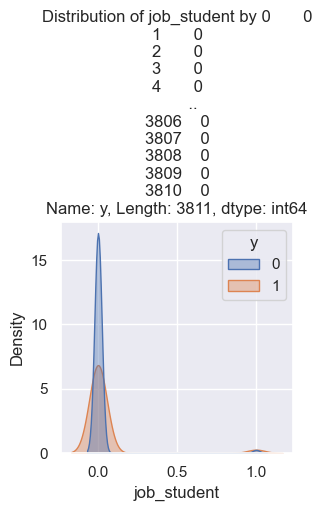

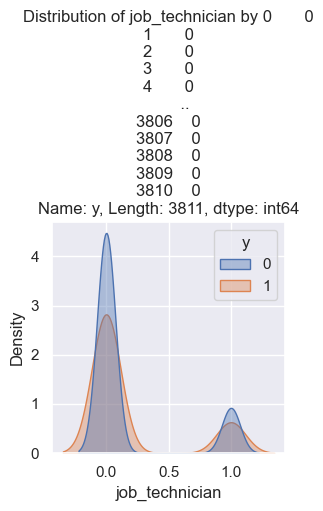

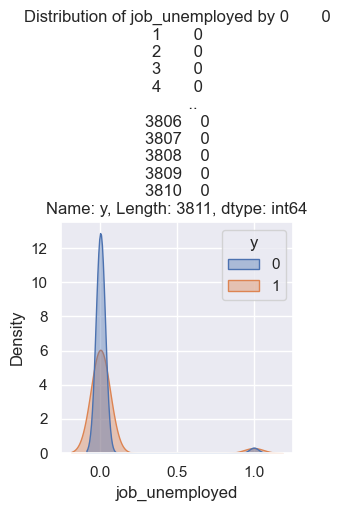

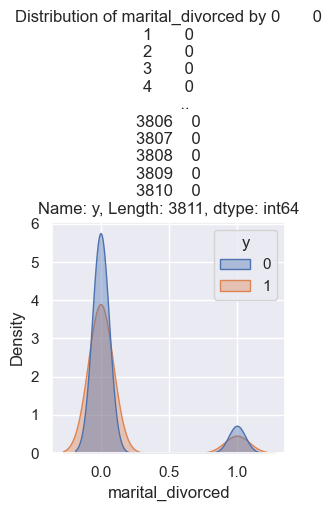

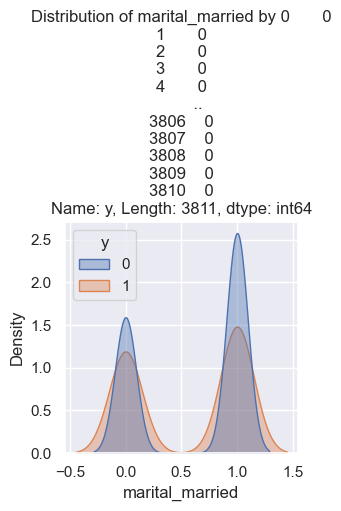

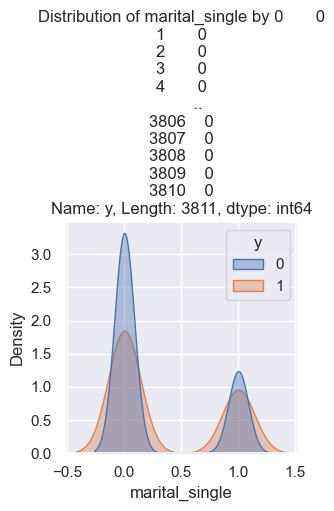

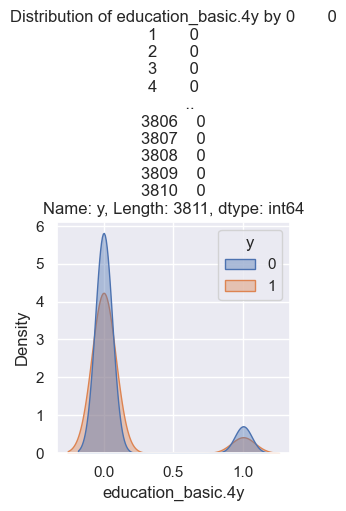

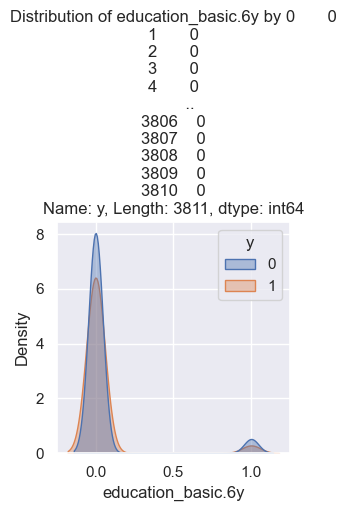

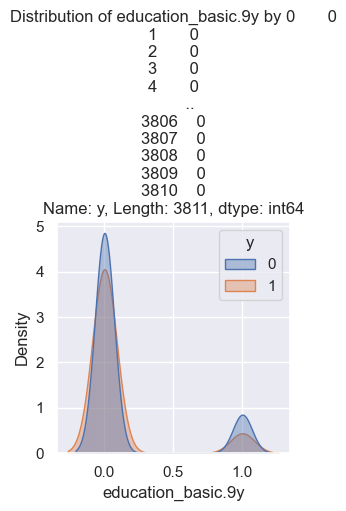

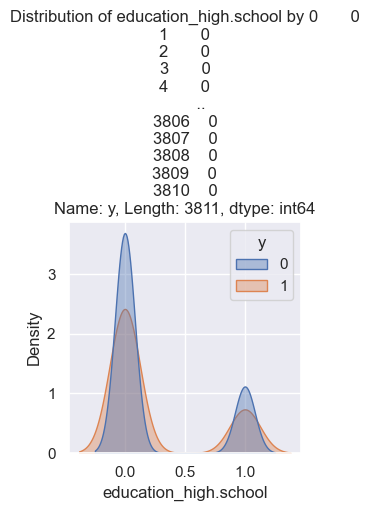

C:\Users\sport\AppData\Local\Temp\ipykernel_3384\1475004586.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


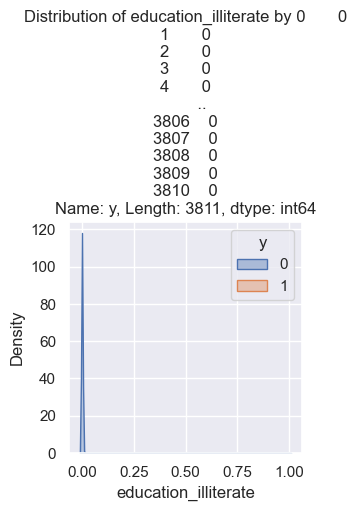

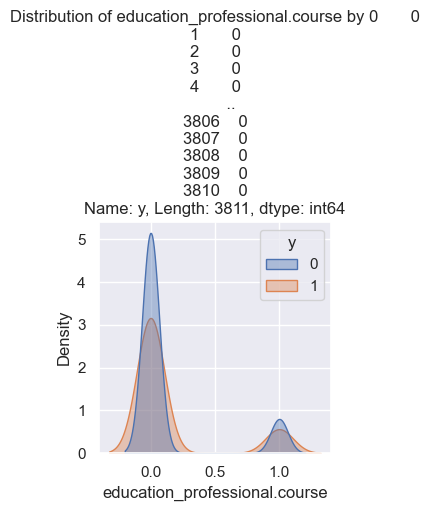

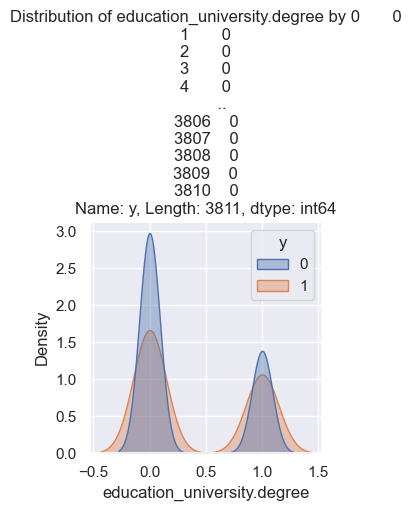

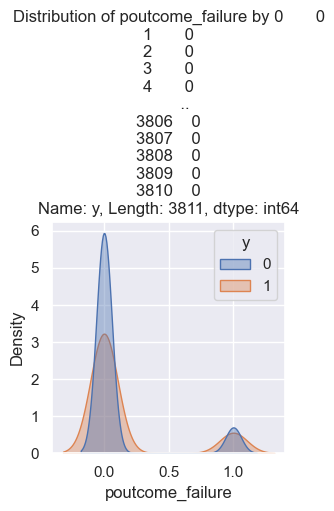

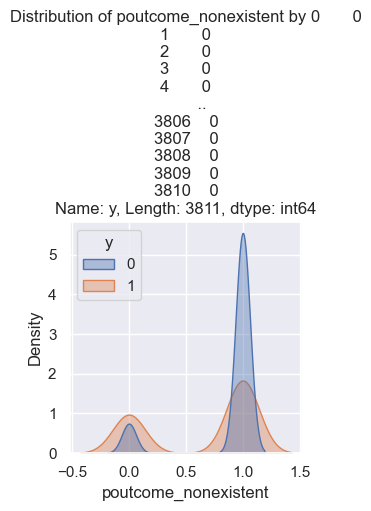

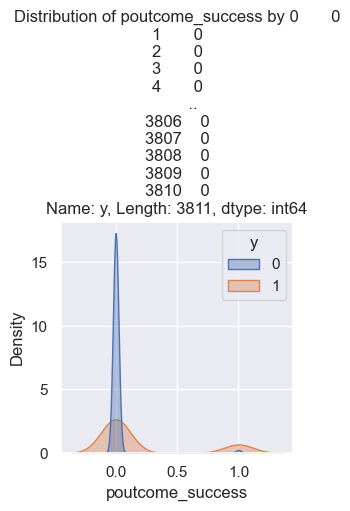

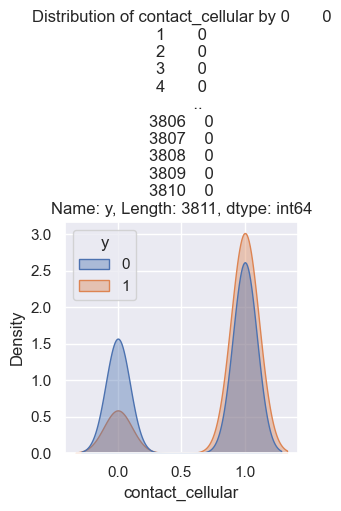

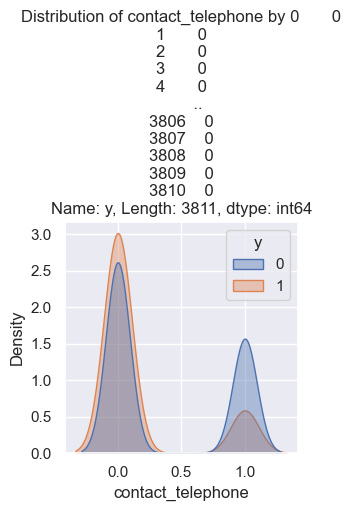

In [59]:
plot_distributions(X, target_col=y)

In [60]:
df_capped = cap_to_99(X)
df_capped.head()

,age,housing,loan,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,poutcome_failure,poutcome_nonexistent,poutcome_success,contact_cellular,contact_telephone
0,30,1,0,487.0,2,999,0,-1.8,92.893,-46.2,...,1,0,0,0,0,0,1,0,1,0
1,39,0,0,346.0,4,999,0,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,1
2,25,1,0,227.0,1,999,0,1.4,94.465,-41.8,...,0,1,0,0,0,0,1,0,0,1
3,47,1,0,58.0,1,999,0,-0.1,93.200,-42.0,...,0,0,0,0,1,0,1,0,1,0
4,32,0,0,128.0,3,999,2,-1.1,94.199,-37.5,...,0,0,0,0,1,1,0,0,1,0


## 2.3 After

In [61]:
display(df_capped.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,3811.0,39.883495,9.956181,19.000000,32.000000,3.800000e+01,47.000000,68.000000
housing,3811.0,0.543689,0.498153,0.000000,0.000000,1.000000e+00,1.000000,1.000000
loan,3811.0,0.166361,0.372453,0.000000,0.000000,0.000000e+00,0.000000,1.000000
duration,3811.0,252.378982,231.311353,0.000000,103.000000,1.800000e+02,316.000000,1232.700000
campaign,3811.0,2.483600,2.235817,1.000000,1.000000,2.000000e+00,3.000000,13.000000
pdays,3811.0,961.467331,189.427840,0.000000,999.000000,9.990000e+02,999.000000,999.000000
previous,3811.0,0.170297,0.443819,0.000000,0.000000,0.000000e+00,0.000000,2.000000
emp.var.rate,3811.0,0.088113,1.557160,-3.400000,-1.800000,1.100000e+00,1.400000,1.400000
cons.price.idx,3811.0,93.574522,0.576646,92.201000,93.075000,9.344400e+01,93.994000,94.601000
cons.conf.idx,3811.0,-40.560798,4.602293,-50.800000,-42.700000,-4.180000e+01,-36.400000,-26.900000


# 3. After Plots

In [62]:
X = df_capped

In [63]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

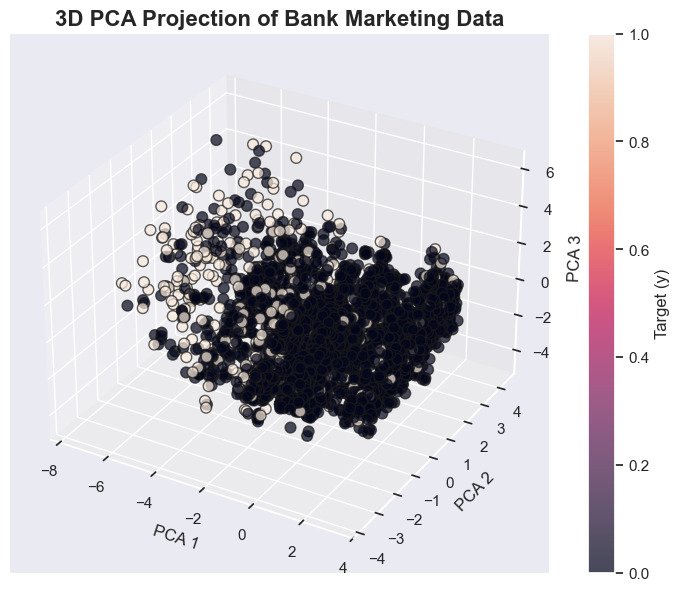

In [64]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], 
    c=y,  alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Bank Marketing Data", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()

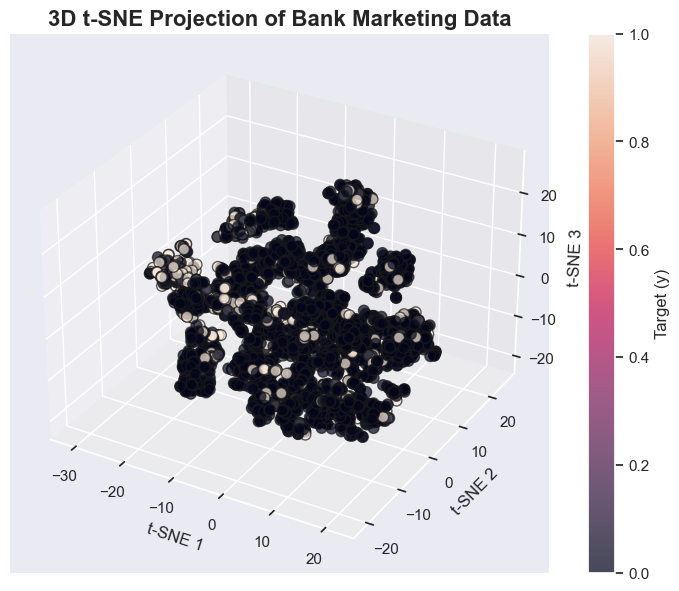

In [65]:
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_tsne_3d[:,0], X_tsne_3d[:,1], X_tsne_3d[:,2],
    c=y, alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.set_title("3D t-SNE Projection of Bank Marketing Data", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()


# 4. Save

In [66]:
df_capped.to_csv(capped_file_path, index=False)
y.to_csv(target_file_path, index=False)


# END